<a href="https://colab.research.google.com/github/sara-i/CUBIG_Covid/blob/main/prepare_SIIM_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chest X-Ray Medical Diagnosis with Deep Learning**

## **KAGGLE DATASET:**
## SIIM-FISABIO-RSNA COVID-19 Detection
https://www.kaggle.com/c/siim-covid19-detection/overview

---

## (This dataset is used for model testing)

## **1. import packages and functions**

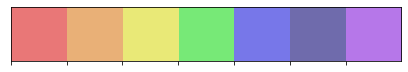

In [ ]:
# Libraries
import os
import re
import wandb
import tqdm
import warnings
import glob
import ast
import cv2
import math
import pandas as pd
import numpy as np
from IPython.display import display_html
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from sklearn.cluster import KMeans
from skimage import morphology, measure

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'siim-fisabio-rsna', '_wandb_kernel': 'aot'}

# Secrets 🤫
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#secret_value_0 = user_secrets.get_secret("wandb")

# Custom colors
my_colors = ["#E97777", "#E9B077", "#E9E977", 
             "#77E977", "#7777E9", "#6F6BAC", "#B677E9"]
sns.palplot(sns.color_palette(my_colors))

# Set Style
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams.update({'font.size': 22})

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'

## **2. Load the Datasets**

This datasets 
- contains 6,334 CXR images for training set
- all cases are COVID-19 positive.
- They classified data into 4 classes 
  - Class 1: Negative for Pneumonia
  - Class 2: Typical Appearance 
  - Class 3: Interminate Appearance
  - Class 4: Atypical Appearance

**Files**

**train_image_level.csv** - the train image-level metadata, with one row for **each image**, including both **correct labels** and any **bounding boxes** in a dictionary format. Some images in both test and train have multiple bounding boxes.


**Read in the data**

Let's open these files using the pandas library

เอา 250 cases in each class.

1.   Download data from external hard drive
2.   indicate 250 cases in each class



In [ ]:
# Read in metadata
train_study = pd.read_csv("/Users/sararas/Downloads/siim-covid19-detection/train_study_level.csv")
train_image = pd.read_csv("/Users/sararas/Downloads/siim-covid19-detection/train_image_level.csv")

print(color.BOLD + "Train Study Shape:" + color.END, train_study.shape, "\n" +
      color.BOLD + "Train Image Shape:" + color.END, train_image.shape, "\n" +
      "\n" +
      "Note: There are {} missing values in train_image.".\
                              format(train_image["boxes"].isna().sum()), "\n" +
      "This happens for labels = 'none' - no checkboxes.", 3*"\n")


# Head of our 2 training metadata
df1_styler = train_study.head(3).style.set_table_attributes("style='display:inline'").\
                                set_caption('TRAIN STUDY')
df2_styler = train_image.head(3).style.set_table_attributes("style='display:inline'").\
                                set_caption('TRAIN IMAGE')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

Train Study Shape: (6054, 5) 
Train Image Shape: (6334, 4) 

Note: There are 2040 missing values in train_image. 
This happens for labels = 'none' - no checkboxes. 





TRAIN STUDY id Negative for Pneumonia Typical Appearance Indeterminate Appearance Atypical Appearance 
 
 0 
 00086460a852_study 
 0 
 1 
 0 
 0 
 
 
 1 
 000c9c05fd14_study 
 0 
 0 
 0 
 1 
 
 
 2 
 00292f8c37bd_study 
 1 
 0 
 0 
 0 
 
 TRAIN IMAGE id boxes label StudyInstanceUID 
 
 0 
 000a312787f2_image 
 [{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}] 
 opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472 
 5776db0cec75 
 
 
 1 
 000c3a3f293f_image 
 nan 
 none 1 0 0 1 1 
 ff0879eb20ed 
 
 
 2 
 0012ff7358bc_image 
 [{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}] 
 opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105 
 9d514ce429a7

## train_study analysis

In [ ]:
# Process id
train_study["study_id"] = train_study["id"].apply(lambda x: x.split("_")[0])

# Counting
pneumonia = train_study["Negative for Pneumonia"]
typical = train_study["Typical Appearance"]
indeterminate = train_study["Indeterminate Appearance"]
atypical = train_study["Atypical Appearance"]

print("Pneumonia =", pneumonia.sum(), "cases")
print("Typical =", typical.sum(), "cases")
print("Indeterminate =", indeterminate.sum(), "cases")
print("Atypical =", atypical.sum(), "cases")
print("-------------------")
print("Total =", pneumonia.sum() + typical.sum() + indeterminate.sum() + atypical.sum(), "cases")

Pneumonia = 1676 cases
Typical = 2855 cases
Indeterminate = 1049 cases
Atypical = 474 cases
-------------------
Total = 6054 cases


In [ ]:
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id
0,00086460a852_study,0,1,0,0,00086460a852
1,000c9c05fd14_study,0,0,0,1,000c9c05fd14
2,00292f8c37bd_study,1,0,0,0,00292f8c37bd
3,005057b3f880_study,1,0,0,0,005057b3f880
4,0051d9b12e72_study,0,0,0,1,0051d9b12e72


## train_image analysis

In [ ]:
# Process id
train_image["image_id"] = train_image["id"].apply(lambda x: x.split("_")[0])

# Counting
df = train_image["label"].apply(lambda x: x.split(" ")[0]).\
                                    value_counts().reset_index()

print(color.BOLD + "How many images have a bounding box present?" + color.END,
"\n" + 
      "There are {} missing of boundary boxes in train_image.".\
                            format(train_image["boxes"].isna().sum()),
"\n" + 
      "and there are {} cases that boundary boxes were presented.".\
                            format(train_image["boxes"].count()))

How many images have a bounding box present? 
There are 2040 missing of boundary boxes in train_image. 
and there are 4294 cases that boundary boxes were presented.


### ในจำนวน 6054 cases มีเพียง 4294 cases ที่มี boundary box
### ต่อไปจะนำ train_label and train_images มา merge กันให้เป็น file เดียว

In [ ]:
# Merge all info together
train = pd.merge(train_image, train_study, 
                 left_on="StudyInstanceUID", right_on="study_id")

train.drop(["id_x", "StudyInstanceUID", "id_y"], axis=1, inplace=True)
train.head()

,boxes,label,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,000a312787f2,0,1,0,0,5776db0cec75
1,NaN,none 1 0 0 1 1,000c3a3f293f,1,0,0,0,ff0879eb20ed
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,0012ff7358bc,0,1,0,0,9d514ce429a7
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,001398f4ff4f,0,0,0,1,28dddc8559b2
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,001bd15d1891,0,1,0,0,dfd9fdd85a3e


In [ ]:
print(color.BOLD + "Number of row and col in 'train' dataframe =" + color.END, train.shape,\
"\n" + "No boxes =", train["boxes"].isnull().sum(), "cases")

Number of row and col in 'train' dataframe = (6334, 8) 
No boxes = 2040 cases


## Keep only patient ID that has boundary boxes

In [ ]:
train = train[train['boxes'].notna()]
print(color.BOLD + "Number of row and col in 'train' dataframe =" + color.END, train.shape,\
"\n" + "No boxes =", train["boxes"].isnull().sum(), "cases")

Number of row and col in 'train' dataframe = (4294, 8) 
No boxes = 0 cases


In [ ]:
train = train[train['Negative for Pneumonia'] == 0]
train = train[train['Atypical Appearance'] == 0] 

## Create a new dataframe that will represent COVID-19 positive case in our research

#### which has 250 cases in each class.

In [ ]:
train["class"] = train.loc[:, "Negative for Pneumonia":"Atypical Appearance"].idxmax(axis=1)

In [ ]:
train.head()

,boxes,label,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id,class
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,000a312787f2,0,1,0,0,5776db0cec75,Typical Appearance
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,0012ff7358bc,0,1,0,0,9d514ce429a7,Typical Appearance
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,001bd15d1891,0,1,0,0,dfd9fdd85a3e,Typical Appearance
5,"[{'x': 1857.2065, 'y': 508.30565, 'width': 376...",opacity 1 1857.2065 508.30565 2233.23384 907.8...,0022227f5adf,0,0,1,0,84543edc24c2,Indeterminate Appearance
7,"[{'x': 276.72917, 'y': 627.42968, 'width': 910...",opacity 1 276.72917 627.42968 1187.31776 2283....,002e9b2128d0,0,1,0,0,0717c8ac304f,Typical Appearance


In [ ]:
train.loc[:,"class"].value_counts()

Typical Appearance          2854
Indeterminate Appearance    1049
Name: class, dtype: int64

In [ ]:
positive_df = train.groupby('class').head(500)

In [ ]:
positive_df.drop(positive_df.loc[:,"Negative for Pneumonia":"Atypical Appearance"], inplace = True, axis = 1)
print(positive_df.shape)
positive_df.head()

(1000, 5)


,boxes,label,image_id,study_id,class
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,000a312787f2,5776db0cec75,Typical Appearance
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,0012ff7358bc,9d514ce429a7,Typical Appearance
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,001bd15d1891,dfd9fdd85a3e,Typical Appearance
5,"[{'x': 1857.2065, 'y': 508.30565, 'width': 376...",opacity 1 1857.2065 508.30565 2233.23384 907.8...,0022227f5adf,84543edc24c2,Indeterminate Appearance
7,"[{'x': 276.72917, 'y': 627.42968, 'width': 910...",opacity 1 276.72917 627.42968 1187.31776 2283....,002e9b2128d0,0717c8ac304f,Typical Appearance


## สรุปว่าจะเอา >1000 (คือเยอะที่สุดเท่าที่จะเป็นไปได้ แต่ต้องมี bounding box)